# Sea Surface Temperature (SST) sensors
Optimal sensor placement for NOAA SST dataset.

Note that you will need the additional package `netCDF4` to run this notebook.

In [1]:
from ftplib import FTP

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import netCDF4

import pysensors as ps

Imports latest NOAA-SST weekly means (1990-present), published online in netCDF format

In [2]:
# Import and save data locally
ftp = FTP('ftp.cdc.noaa.gov')
ftp.login()
ftp.cwd('/Datasets/noaa.oisst.v2/')

filenames = ['sst.wkmean.1990-present.nc', 'lsmask.nc']

for filename in filenames:
    localfile = open(filename, 'wb')
    ftp.retrbinary('RETR ' + filename, localfile.write, 1024)
    localfile.close()

ftp.quit()

'221 Goodbye.'

In [3]:
f = netCDF4.Dataset('sst.wkmean.1990-present.nc')

lat,lon = f.variables['lat'], f.variables['lon']
SST = f.variables['sst']
sst = SST[:]
print(f)

f = netCDF4.Dataset('lsmask.nc')
mask = f.variables['mask']

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: NOAA Optimum Interpolation (OI) SST V2
    Conventions: CF-1.0
    history: Created 10/2002 by RHS
    comments: Data described in  Reynolds, R.W., N.A. Rayner, T.M.
Smith, D.C. Stokes, and W. Wang, 2002: An Improved In Situ and Satellite
SST Analysis for Climate, J. Climate
    platform: Model
    source: NCEP Climate Modeling Branch
    institution: National Centers for Environmental Prediction
    References: https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html
    NCO: 4.0.0
    dataset_title: NOAA Optimum Interpolation (OI) SST V2
    source_url: http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/
    dimensions(sizes): lat(180), lon(360), time(1600), nbnds(2)
    variables(dimensions): float32 lat(lat), float32 lon(lon), int16 sst(time, lat, lon), float64 time(time), float64 time_bnds(time, nbnds)
    groups: 


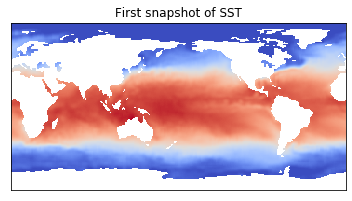

In [4]:
# Plot first snapshot of time series

masks = np.bool_(np.squeeze(mask))
snapshot = float("nan")*np.ones((180,360))
snapshot[masks] = sst[0,masks]

plt.imshow(snapshot, cmap=plt.cm.coolwarm)
plt.xticks([])
plt.yticks([])
plt.title('First snapshot of SST')
#plt.show()
X = sst[:,masks]
X = np.reshape(X.compressed(),X.shape) # convert masked array to array

In [5]:
# Feed into SensorSelector with a SVD basis
model = ps.SensorSelector(
    basis=ps.basis.SVD(n_basis_modes=25),
    n_sensors=25
)
model.fit(X)
sensors = model.get_selected_sensors()
#print(sensors)

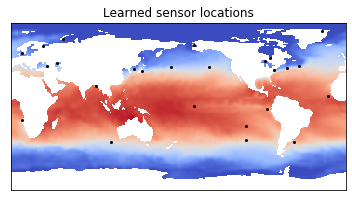

In [6]:
# Plot sensor locations
temp = np.transpose(0*X[1,:])
temp[sensors] = 1
img = 0*snapshot
img[masks] = temp
plt.imshow(snapshot, cmap=plt.cm.coolwarm)
indx = np.where(img==1)
plt.scatter(indx[1],indx[0],4,color='black')
plt.xticks([])
plt.yticks([])
plt.title('Learned sensor locations')
plt.show()